In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab.patches import cv2_imshow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## METHOD-1:EASY OCR

**1.SCENE TEXT DETECTION**

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install easyocr


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils


In [ ]:
def single_line(result,IMAGE_PATH):
  img = cv2.imread(IMAGE_PATH)
  top_left = tuple(result[0][0][0])
  bottom_right = tuple(result[0][0][2])
  text = result[0][1]
  font = cv2.FONT_HERSHEY_SIMPLEX
  img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
  img = cv2.putText(img,text,top_left, font, 0.5,(255,255,255),2,cv2.LINE_AA)
  return img

def multiple_line(result,IMAGE_PATH):
  spacer = 100
  img = cv2.imread(IMAGE_PATH)
  for detection in result: 
      top_left = tuple(detection[0][0])
      bottom_right = tuple(detection[0][2])
      font = cv2.FONT_HERSHEY_SIMPLEX
      text = detection[1]
      img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
      img = cv2.putText(img,text,(20,spacer), font, 0.5,(0,255,0),2,cv2.LINE_AA)
      spacer+=15
  return img

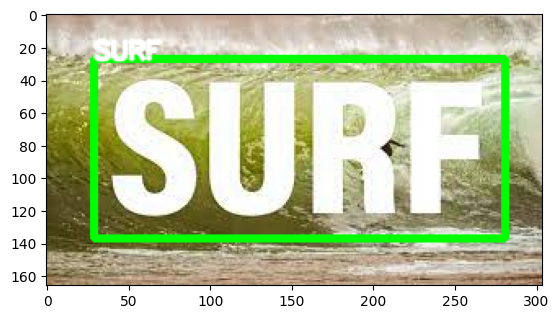

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/Colab_Notebooks/CV_PROJECT_2/text/surf.jpg'

reader=easyocr.Reader(['en'],gpu=False)
result=reader.readtext(IMAGE_PATH)
if len(result)==1:
  image=single_line(result,IMAGE_PATH)
else:
  image=multiple_line(result,IMAGE_PATH)
plt.imshow(image)
plt.show()

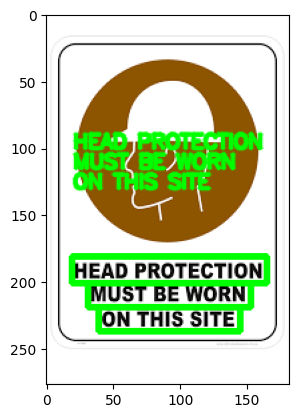

In [ ]:
IMAGE_PATH='/content/drive/MyDrive/Colab_Notebooks/CV_PROJECT_2/sign.png'

reader=easyocr.Reader(['en'],gpu=False)
result=reader.readtext(IMAGE_PATH)
if len(result)==1:
  image=single_line(result,IMAGE_PATH)
else:
  image=multiple_line(result,IMAGE_PATH)
plt.imshow(image)
plt.show()

**2.NUMBER PLATE DETECTION**

1.Read in Image, Grayscale and Blur

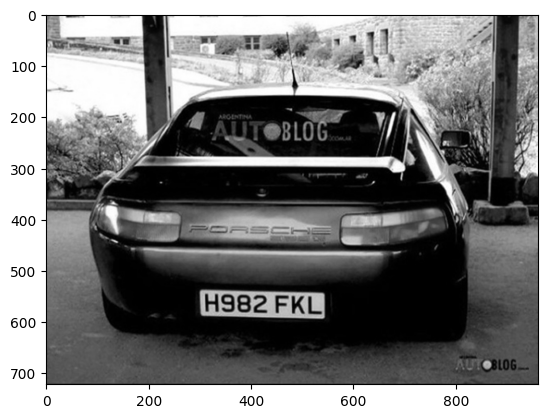

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/CV_PROJECT_2/image4.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

2.Apply filter and find edges for localization

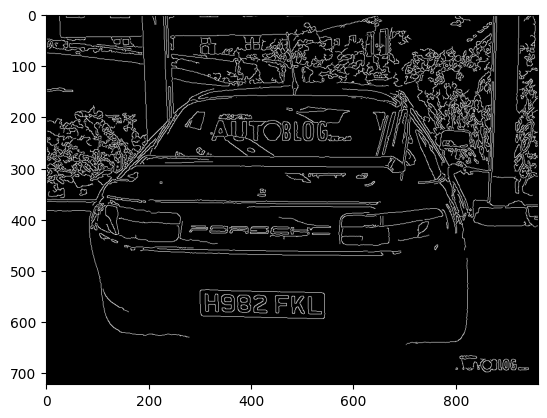

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

3.Find Contours and Apply Mask

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
location = None
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break
location

array([[[300, 540]],

       [[306, 589]],

       [[543, 592]],

       [[538, 543]]], dtype=int32)

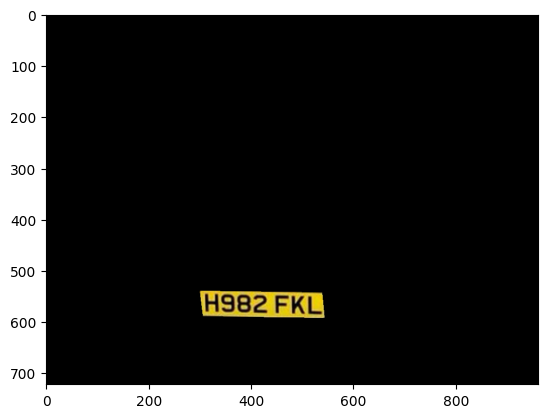

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

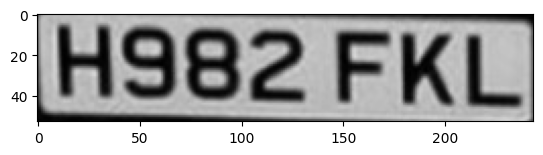

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

4.Use Easy OCR To Read Text

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[0, 0], [244, 0], [244, 53], [0, 53]], 'H982 FKL', 0.9757376651726158)]

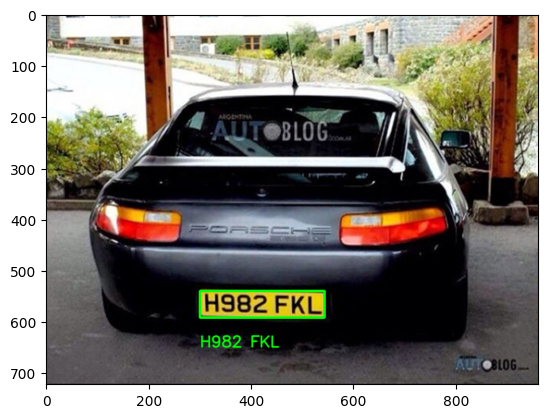

In [ ]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

## METHOD-2:EAST

In [ ]:
!pip install pytesseract==0.3.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import pytesseract
import cv2

In [ ]:
east_path = "/content/drive/MyDrive/Colab_Notebooks/CV_PROJECT_2/text_detector_using-EAST-master/frozen_east_text_detection.pb"
min_confidence_path = 0.5
height_path = 160
width_path = 288

In [ ]:
def model(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image=cv2.resize(image, (500,500))
    orig = image.copy()
    clone1 = image.copy()
    (H, W) = image.shape[:2]
     #set the new width and height and then determine the ratio in change
    (newW, newH) =  (width_path, height_path)
    rW = W / float(newW)
    rH = H / float(newH)

    #resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    net = cv2.dnn.readNet(east_path)

    #construct a blob from the image and then perform a forward pass of
    #the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB = True, crop = False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    #show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    #loop over the number of rows
    for y in range(0, numRows):
      scoresData = scores[0, 0, y]
      xData0 = geometry[0, 0, y]
      xData1 = geometry[0, 1, y]
      xData2 = geometry[0, 2, y]
      xData3 = geometry[0, 3, y]
      anglesData = geometry[0, 4, y]
      
      count = 0
      #loop over the number of colums
      for x in range(0, numCols):
        #if score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5:
          continue
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        #extract the rotation angle for the prediction and then
        #compute the sine and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        #use the geometry volume to derive the width and height of the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        #compute both the starting and ending (x, y)-coordinates for
        #the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        #add the boundig box coordinates and probability score to 
        #our respetive lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])
        return rW,rH,rects,confidences,orig

In [ ]:
def text_detection(rW,rH,rects,confidences,orig):
    #apply non_max_suppresion to supress weak, overlapping bounding boxes
    boxes = non_max_suppression(np.array(rects), probs = confidences)
    print(boxes)
    roi = []
    #loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
      #scale the bounding box coordinates based on the respective ratios
      startX = int(startX * rW)
      startY = int(startY * rH)
      endX = int(endX * rW)
      endY = int(endY * rH)

      #draw the bounding box on the image
      cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255 , 0), 2)
      roi.append([startY, endY, startX, endX])
    for i in roi:
      temp = orig[i[0]:i[1], i[2]:i[3]]
      cus_config = r'--oem 3 --psm 6'
      text = pytesseract.image_to_string(temp, config= cus_config)
      return text,temp

Image 1

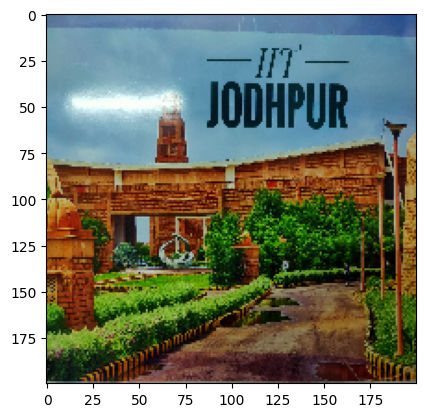

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_path='/content/drive/MyDrive/Colab_Notebooks/CV_PROJECT_2/iitj_image.jpg'

img1 = cv2.imread(image_path)
img1=cv2.resize(img1, (200,200))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# Plot image
plt.imshow(img1)
plt.show()

In [ ]:
rW,rH,rects,confidences,orig=model(image_path)
text,temp=text_detection(rW,rH,rects,confidences,orig)
print(text)

[INFO] text detection took 0.673692 seconds
[[123  23 240  51]]
JODHPUR



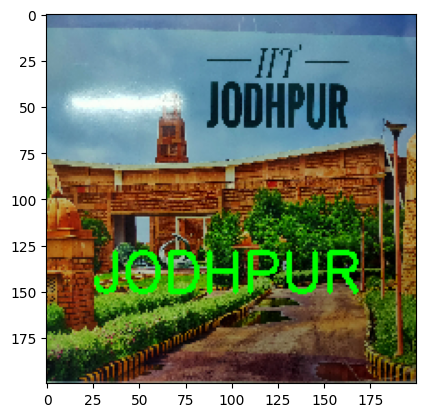

In [ ]:
import cv2
x=len(text)
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
position = (25,150)
color = (0, 255, 0)
thickness = 2
cv2.putText(img1, text[0:x-2], position, font, font_scale, color, thickness)
plt.imshow(img1)

Image 2

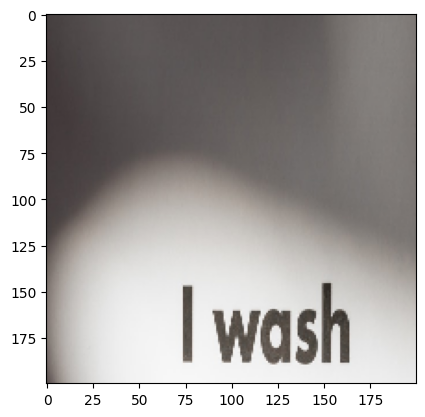

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_path='/content/drive/MyDrive/Colab_Notebooks/CV_PROJECT_2/text_detector_using-EAST-master/hands.jpg'

img1 = cv2.imread(image_path)
img1=cv2.resize(img1, (200,200))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# Plot image
plt.imshow(img1)
plt.show()

In [ ]:
rW,rH,rects,confidences,orig=model(image_path)
text,temp=text_detection(rW,rH,rects,confidences,orig)
print(text)

[INFO] text detection took 0.323039 seconds
[[123 116 240 154]]
wash



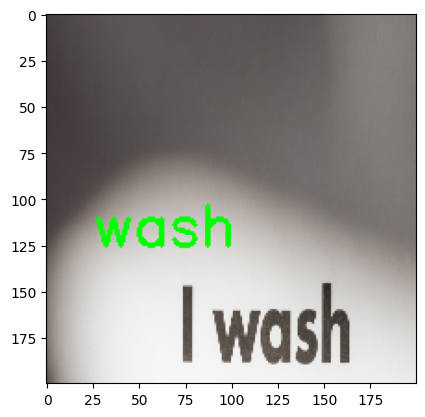

In [ ]:
import cv2
x=len(text)
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
position = (25,125)
color = (0, 255, 0)
thickness = 2
cv2.putText(img1, text[0:x-2], position, font, font_scale, color, thickness)
plt.imshow(img1)

Performance Metric

In [ ]:
!pip install editdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import editdistance

def wer(gt, pred):
    # convert both lists of strings to lowercase
    gt = [s.lower() for s in gt]
    pred = [s.lower() for s in pred]
    
    # calculate the Levenshtein distance between the two lists of strings
    distance = editdistance.eval(gt, pred)
    
    wer = distance / len(gt)  
    return wer

In [ ]:
gt_labels = ["JODHPUR", "I WASH" ,"SURF"]
pred_labels = ["JODHPUR ", "WASH","SURF"]

wer_score = wer(gt_labels, pred_labels)
print("WER: ", wer_score)


WER:  0.6666666666666666
